In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#import model
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
matplotlib.style.use('ggplot')
from torchvision.datasets import MNIST
import os
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import io
import math 
import cv2

from typing import *
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm, trange

# NN
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import STL10

from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Distribution, Bernoulli, Normal
import torch.nn.functional as F
from torch.nn.functional import binary_cross_entropy

# other  libraries...!!!
%matplotlib inline
import argparse
from skimage.util import random_noise

import time

In [19]:
#############################
#        CLASS              #
############################


# output features for the encoder and input features for the decoder
features = 600
# define a simple linear VAE

def un_flatten(x, channels, h, w):
        return x.view(x.size(0), channels, h, w)
    
def flatten(x):
        return x.view(x.size(0), -1)

class ConvVAE(nn.Module):
    
    # 4 linear layers. MINST data set 96*96*3 image = 27648. 
    
    def __init__(self):
        
        super(ConvVAE, self).__init__()

        self.encode = nn.Sequential(
            # 3 x 96 x 96 -> 3 x 96 x 96
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            # 3 x 96 x 96 -> 32 x 32 x 32
            nn.Conv2d(3, 32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32 x 32 x 32 -> 64 x 10 x 10
            nn.Conv2d(32, 64, kernel_size=5, stride=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 10 x 10 -> 128 x 4 x 4
            nn.Conv2d(64, 128, kernel_size=5, stride=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #
            # 128 x 4 x 4 -> 256 x 2 x 2
            # equivalent to 1024 x 1 x 1 when flattened
            #
            nn.Conv2d(128, 256, kernel_size=3, stride=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # fully-connected and latent space
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)

        self.decode = nn.Sequential(
            # 256 x 2 x 2 -> 128 x 4 x 4
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 128 x 4 x 4 -> 64 x 10 x 10
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 10 x 10 -> 32 x 32 x 32
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32 x 32 x 32 -> 3 x 96 x 96
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            # 3 x 96 x 96 -> 3 x 96 x 96
            nn.ConvTranspose2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )



    #ENCODER
    def encoder(self, x):
        h = flatten(self.encode(x))
        z, mu, log_var = self.bottleneck(h)
        return z, mu, log_var

    def decoder(self, z):
        z = self.fc3(z)
        z = self.decode(un_flatten(z, channels=256, h=2, w=2))
        return z
    #REPARAMETERIZE
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        #Returns a new tensor with the exponential of the elements of the input tensor input
        std = torch.exp(0.5*log_var) 
        #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    #FORWARD FUNCTION  
    def forward(self, x,high_res_image):
        self.high_res_image = high_res_image
        # encoding
         #Applies the rectified linear unit function element-wise.
        x_org = x
        z, mu, log_var = self.encoder(x)
        reconstruction = self.decoder(z)
        
        BCE, KLD, loss = self.elbo(x_org, reconstruction, mu, log_var)
        
        return reconstruction, mu, log_var , BCE, KLD, loss, z
    
    
    def bottleneck(self, h):
        mu, log_var = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

    #LOSS FUNCTION  
    def elbo(self, x, reconstruction, mu, log_var) :
        Mse_loss = nn.MSELoss()
        MSE = Mse_loss(reconstruction, self.high_res_image)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = KLD + MSE
        
        return MSE, KLD, loss
        

In [3]:
"""#### Initialize"""

#############################
#        ARGUMENTS          #
############################


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}


In [4]:
#############################
#        PARAMETERS          #
############################

batch_size = 64
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)  
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)+1
  height = int(small_image.shape[0] * 100 / scale_percent)+1
  dim = (width, height)  
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA) 
  return low_res_image, image

In [6]:
from torchvision.datasets import STL10

class STL10dataset(STL10):
  def __getitem__(self, index:int):
    img = self.data[index]

    img, target = pixalate_image(np.transpose(img, (1, 2, 0)))

    if self.transform is not None:
        img = self.transform(img)

    if self.target_transform is not None:
        target = self.target_transform(target)

    return img, target

In [7]:
from skimage.metrics import structural_similarity as ssim

def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


def compare_images(target, ref):  
    return (psnr(target, ref), ssim(target, ref, multichannel =True))

In [8]:
# transforms for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((64, 64)),
    #transforms.RandomHorizontalFlip(p=0.25),
    #transforms.RandomPerspective(p=0.25),
    #transforms.ColorJitter(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    ])

# transforms for test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((64, 64))
])

# transforms for original image
target_transform = transforms.Compose([
                                transforms.ToTensor(),
                                #transforms.Resize((64, 64))
                            ])

In [9]:
# train and validation data
train_data = STL10dataset(
    root='./data',
    split = 'train',
    download=True,
    transform=train_transform,
    target_transform=target_transform
)

val_data = STL10dataset(
    root='./data',
    split = 'test',
    download=True,
    transform=test_transform,
    target_transform=target_transform
)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Split data into validation and test
test_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4)), len(val_data)))
val_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4))))

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

In [12]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

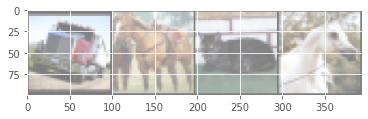

In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))


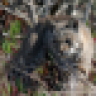

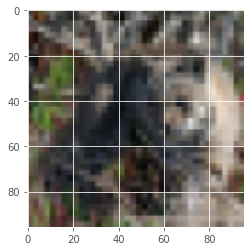

In [14]:

#choose witch image you want to see from 60000
single_image = 1

#take the labels for each train image 


with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    #data = data.to(device)
    x = images[1].size()
    # Reshape image
    plt.imshow(images[1].permute(1, 2, 0))

white_torch = images[1]

torchvision.transforms.ToPILImage()(white_torch)

In [15]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.size())
compare_images(images[1].permute(1, 2, 0).numpy(),labels[1].permute(1, 2, 0).numpy())

torch.Size([64, 3, 96, 96])


(69.61835532478733, 0.813845395745633)

In [16]:
#############################
#     TRAINING FUNCTION     #
############################

def fit(model, dataloader):
    
    start = time.time()
    model.train()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0
  
    
    
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, high_res = data
        
        data = data.to(device)
        
       

        high_res = high_res.to(device)
        

        optimizer.zero_grad()
        start = time.time()
        reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
        
        
        running_loss +=   loss.item()
        bce_running_loss += bce.item()
        kl_running_loss += kl.item()
        loss.backward()
        optimizer.step()
        end = time.time()
        #print("Time inside fit: ", end-start)
    train_loss = running_loss/len(dataloader.dataset)
    train_loss_bce = bce_running_loss/len(dataloader.dataset)
    train_loss_kl = kl_running_loss/len(dataloader.dataset)
    

   
    return train_loss, train_loss_bce, train_loss_kl

"""### The Validation Function"""

#############################
#     VALIDATE FUNCTION     #
############################
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            

            high_res = high_res.to(device)
           

            reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
            
            running_loss += loss.item()
            bce_running_loss += bce.item()
            kl_running_loss += kl.item()

            
    val_loss = running_loss/len(dataloader.dataset)
    val_loss_bce = bce_running_loss/len(dataloader.dataset)
    val_loss_kl = kl_running_loss/len(dataloader.dataset)

    return val_loss, val_loss_bce, val_loss_kl


In [20]:
"""#### Initializing the Model, the Optimizer and the Loss Function"""
epochs = 200
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
#############################
#            RUN            #
############################

train_loss = []
train_loss_bce = []
train_loss_kl = []

val_loss = []
val_loss_bce = []
val_loss_kl = []

start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss, train_epoch_loss_bce, train_epoch_loss_kl = fit(model, train_loader)    
    end = time.time()
    
    val_epoch_loss, val_epoch_loss_bce, val_epoch_loss_kl = validate(model, test_loader)

    
    print(end-start)
    train_loss.append(train_epoch_loss)
    train_loss_bce.append(train_epoch_loss_bce)
    train_loss_kl.append(train_epoch_loss_kl)
    
    val_loss.append(val_epoch_loss)
    val_loss_bce.append(val_epoch_loss_bce)
    val_loss_kl.append(val_epoch_loss_kl)    
    
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")





Epoch 1 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

4.4057841300964355
Train Loss: 7.2780
Val Loss: 0.2799
Epoch 2 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

11.107604026794434
Train Loss: 0.2073
Val Loss: 0.1268
Epoch 3 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

17.637568473815918
Train Loss: 0.1315
Val Loss: 0.1054
Epoch 4 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

24.217692613601685
Train Loss: 0.0985
Val Loss: 0.0681
Epoch 5 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

30.85838747024536
Train Loss: 0.0772
Val Loss: 0.1110
Epoch 6 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

37.63066053390503
Train Loss: 0.0645
Val Loss: 0.0658
Epoch 7 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

44.36789059638977
Train Loss: 0.0562
Val Loss: 0.0796
Epoch 8 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

51.01252627372742
Train Loss: 0.0557
Val Loss: 0.0518
Epoch 9 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

57.74622559547424
Train Loss: 0.0535
Val Loss: 0.0530
Epoch 10 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

64.45932674407959
Train Loss: 0.0433
Val Loss: 0.0356
Epoch 11 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

71.90772843360901
Train Loss: 0.0411
Val Loss: 0.0474
Epoch 12 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

79.04677653312683
Train Loss: 0.0385
Val Loss: 0.0342
Epoch 13 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

85.73984575271606
Train Loss: 0.0336
Val Loss: 0.0364
Epoch 14 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

92.46393013000488
Train Loss: 0.0301
Val Loss: 0.0263
Epoch 15 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

99.35633158683777
Train Loss: 0.0246
Val Loss: 0.0346
Epoch 16 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

106.11275029182434
Train Loss: 0.0407
Val Loss: 0.0261
Epoch 17 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

112.99583578109741
Train Loss: 0.0305
Val Loss: 0.0436
Epoch 18 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

119.8773341178894
Train Loss: 0.0244
Val Loss: 0.0232
Epoch 19 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

126.59747838973999
Train Loss: 0.0197
Val Loss: 0.0133
Epoch 20 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

133.4450364112854
Train Loss: 0.0141
Val Loss: 0.0136
Epoch 21 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

140.1840090751648
Train Loss: 0.0116
Val Loss: 0.0153
Epoch 22 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

146.96737837791443
Train Loss: 0.0142
Val Loss: 0.0250
Epoch 23 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

153.7774941921234
Train Loss: 0.0149
Val Loss: 0.0202
Epoch 24 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

160.62653160095215
Train Loss: 0.0171
Val Loss: 0.0163
Epoch 25 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

167.41629457473755
Train Loss: 0.0170
Val Loss: 0.0196
Epoch 26 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

174.19797730445862
Train Loss: 0.0149
Val Loss: 0.0184
Epoch 27 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

180.97337365150452
Train Loss: 0.0259
Val Loss: 0.0189
Epoch 28 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

187.78419089317322
Train Loss: 0.0140
Val Loss: 0.0229
Epoch 29 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

194.73478364944458
Train Loss: 0.0198
Val Loss: 0.0105
Epoch 30 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

201.46507477760315
Train Loss: 0.0134
Val Loss: 0.0054
Epoch 31 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

208.26309490203857
Train Loss: 0.0070
Val Loss: 0.0056
Epoch 32 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

215.03907132148743
Train Loss: 0.0100
Val Loss: 0.0068
Epoch 33 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

221.88329553604126
Train Loss: 0.0142
Val Loss: 0.0054
Epoch 34 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

228.83691263198853
Train Loss: 0.0096
Val Loss: 0.0106
Epoch 35 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

235.60433340072632
Train Loss: 0.0115
Val Loss: 0.0045
Epoch 36 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

242.4763879776001
Train Loss: 0.0099
Val Loss: 0.0048
Epoch 37 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

249.40477776527405
Train Loss: 0.0113
Val Loss: 0.0035
Epoch 38 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

256.3411536216736
Train Loss: 0.0051
Val Loss: 0.0030
Epoch 39 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

263.207882642746
Train Loss: 0.0056
Val Loss: 0.0023
Epoch 40 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

270.0834050178528
Train Loss: 0.0059
Val Loss: 0.0023
Epoch 41 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

277.03425002098083
Train Loss: 0.0043
Val Loss: 0.0024
Epoch 42 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

284.82193398475647
Train Loss: 0.0054
Val Loss: 0.0028
Epoch 43 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

291.8780641555786
Train Loss: 0.0159
Val Loss: 0.0029
Epoch 44 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

298.7530565261841
Train Loss: 0.0197
Val Loss: 0.0051
Epoch 45 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

305.6321017742157
Train Loss: 0.0074
Val Loss: 0.0020
Epoch 46 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

312.66503500938416
Train Loss: 0.0044
Val Loss: 0.0017
Epoch 47 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

319.5477578639984
Train Loss: 0.0034
Val Loss: 0.0015
Epoch 48 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

326.50498700141907
Train Loss: 0.0029
Val Loss: 0.0012
Epoch 49 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

333.40146827697754
Train Loss: 0.0038
Val Loss: 0.0012
Epoch 50 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

340.28828287124634
Train Loss: 0.0026
Val Loss: 0.0013
Epoch 51 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

347.29879426956177
Train Loss: 0.0037
Val Loss: 0.0012
Epoch 52 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

354.17161321640015
Train Loss: 0.0044
Val Loss: 0.0013
Epoch 53 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

361.1501798629761
Train Loss: 0.0348
Val Loss: 0.0017
Epoch 54 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

368.0420711040497
Train Loss: 0.0048
Val Loss: 0.0012
Epoch 55 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

375.03964710235596
Train Loss: 0.0038
Val Loss: 0.0011
Epoch 56 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

381.95993399620056
Train Loss: 0.0019
Val Loss: 0.0011
Epoch 57 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

388.9576983451843
Train Loss: 0.0018
Val Loss: 0.0012
Epoch 58 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

395.91390442848206
Train Loss: 0.0020
Val Loss: 0.0011
Epoch 59 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

402.94934368133545
Train Loss: 0.0017
Val Loss: 0.0011
Epoch 60 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

409.943158864975
Train Loss: 0.0016
Val Loss: 0.0011
Epoch 61 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

416.90693712234497
Train Loss: 0.0016
Val Loss: 0.0015
Epoch 62 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

423.85481214523315
Train Loss: 0.0023
Val Loss: 0.0011
Epoch 63 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

430.74150133132935
Train Loss: 0.0016
Val Loss: 0.0011
Epoch 64 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

437.98415303230286
Train Loss: 0.0013
Val Loss: 0.0011
Epoch 65 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

444.9075765609741
Train Loss: 0.0013
Val Loss: 0.0011
Epoch 66 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

451.93143224716187
Train Loss: 0.0014
Val Loss: 0.0011
Epoch 67 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

458.8831641674042
Train Loss: 0.0053
Val Loss: 0.0011
Epoch 68 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

465.88175654411316
Train Loss: 0.3322
Val Loss: 2.7263
Epoch 69 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

472.9277575016022
Train Loss: 0.0868
Val Loss: 0.0016
Epoch 70 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

479.916303396225
Train Loss: 0.0013
Val Loss: 0.0012
Epoch 71 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

486.91305899620056
Train Loss: 0.0074
Val Loss: 0.0013
Epoch 72 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

495.06613421440125
Train Loss: 0.0023
Val Loss: 0.0012
Epoch 73 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

502.1871645450592
Train Loss: 0.0017
Val Loss: 0.0011
Epoch 74 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

509.20985221862793
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 75 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

516.2184972763062
Train Loss: 0.0016
Val Loss: 0.0011
Epoch 76 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

523.4299993515015
Train Loss: 0.0014
Val Loss: 0.0011
Epoch 77 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

530.6908383369446
Train Loss: 0.0034
Val Loss: 0.0011
Epoch 78 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

537.790495634079
Train Loss: 0.0020
Val Loss: 0.0011
Epoch 79 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

544.8929121494293
Train Loss: 0.0015
Val Loss: 0.0011
Epoch 80 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

552.034904718399
Train Loss: 0.0014
Val Loss: 0.0011
Epoch 81 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

559.1849722862244
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 82 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

566.6407902240753
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 83 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

573.6751580238342
Train Loss: 0.0017
Val Loss: 0.0011
Epoch 84 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

580.768812417984
Train Loss: 0.0016
Val Loss: 0.0011
Epoch 85 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

587.9097242355347
Train Loss: 0.0018
Val Loss: 0.0011
Epoch 86 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

595.0938317775726
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 87 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

602.1168348789215
Train Loss: 0.0013
Val Loss: 0.0011
Epoch 88 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

609.2841010093689
Train Loss: 0.0081
Val Loss: 0.0013
Epoch 89 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

616.3941719532013
Train Loss: 0.0095
Val Loss: 0.0114
Epoch 90 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

623.6087634563446
Train Loss: 0.0037
Val Loss: 0.0014
Epoch 91 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

630.7818040847778
Train Loss: 0.0015
Val Loss: 0.0011
Epoch 92 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

637.8639931678772
Train Loss: 0.0020
Val Loss: 0.0011
Epoch 93 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

644.9694502353668
Train Loss: 0.0069
Val Loss: 0.0012
Epoch 94 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

652.2525582313538
Train Loss: 0.0025
Val Loss: 0.0012
Epoch 95 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

659.2653348445892
Train Loss: 0.0023
Val Loss: 0.0011
Epoch 96 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

666.4010820388794
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 97 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

673.5048534870148
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 98 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

680.8270723819733
Train Loss: 0.0014
Val Loss: 0.0011
Epoch 99 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

687.9551482200623
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 100 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

695.0652964115143
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 101 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

702.1968150138855
Train Loss: 0.0023
Val Loss: 0.0011
Epoch 102 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

710.5792655944824
Train Loss: 0.0022
Val Loss: 0.0011
Epoch 103 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

717.8192794322968
Train Loss: 0.0014
Val Loss: 0.0012
Epoch 104 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

725.0427331924438
Train Loss: 0.0013
Val Loss: 0.0011
Epoch 105 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

732.1995227336884
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 106 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

739.3340563774109
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 107 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

746.8132846355438
Train Loss: 0.0015
Val Loss: 0.0011
Epoch 108 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

753.9972133636475
Train Loss: 0.0015
Val Loss: 0.0011
Epoch 109 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

761.1946446895599
Train Loss: 0.0014
Val Loss: 0.0011
Epoch 110 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

768.4322807788849
Train Loss: 0.0015
Val Loss: 0.0011
Epoch 111 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

775.9025003910065
Train Loss: 0.0014
Val Loss: 0.0011
Epoch 112 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

783.0183136463165
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 113 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

790.3022677898407
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 114 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

797.6223795413971
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 115 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

804.9701886177063
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 116 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

812.1303141117096
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 117 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

819.3710196018219
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 118 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

826.7291038036346
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 119 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

834.1287868022919
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 120 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

841.3666558265686
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 121 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

848.6559910774231
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 122 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

855.9520342350006
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 123 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

863.2503988742828
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 124 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

870.6446371078491
Train Loss: 0.0015
Val Loss: 0.0012
Epoch 125 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

877.9502894878387
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 126 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

885.3130831718445
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 127 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

892.6441440582275
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 128 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

900.0702757835388
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 129 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

907.3545587062836
Train Loss: 0.0014
Val Loss: 0.0012
Epoch 130 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

914.6729905605316
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 131 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

923.0381300449371
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 132 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

930.5583167076111
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 133 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

937.8482766151428
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 134 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

945.1858534812927
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 135 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

952.5800359249115
Train Loss: 0.0013
Val Loss: 0.0012
Epoch 136 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

960.2253768444061
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 137 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

967.5226075649261
Train Loss: 0.0014
Val Loss: 0.0012
Epoch 138 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

974.7461271286011
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 139 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

982.120748758316
Train Loss: 0.0012
Val Loss: 0.0012
Epoch 140 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

989.5260720252991
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 141 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

996.8481166362762
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 142 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1004.1419594287872
Train Loss: 0.0014
Val Loss: 0.0013
Epoch 143 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1011.3818898200989
Train Loss: 0.0028
Val Loss: 0.0020
Epoch 144 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1018.7515778541565
Train Loss: 0.0015
Val Loss: 0.0011
Epoch 145 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1026.0633549690247
Train Loss: 0.0011
Val Loss: 0.0012
Epoch 146 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1033.495257139206
Train Loss: 0.0012
Val Loss: 0.0011
Epoch 147 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1040.9248123168945
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 148 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1048.5891268253326
Train Loss: 0.0020
Val Loss: 0.0016
Epoch 149 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1056.0679817199707
Train Loss: 0.0027
Val Loss: 0.0015
Epoch 150 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1063.4802114963531
Train Loss: 0.0022
Val Loss: 0.0012
Epoch 151 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1070.8643126487732
Train Loss: 0.0015
Val Loss: 0.0011
Epoch 152 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1078.2996201515198
Train Loss: 0.0014
Val Loss: 0.0012
Epoch 153 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1086.0009787082672
Train Loss: 0.0017
Val Loss: 0.0013
Epoch 154 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1093.4067335128784
Train Loss: 0.0014
Val Loss: 0.0011
Epoch 155 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1100.8341763019562
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 156 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1108.270455121994
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 157 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1115.800181388855
Train Loss: 0.0020
Val Loss: 0.0017
Epoch 158 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1123.347081899643
Train Loss: 0.0025
Val Loss: 0.0011
Epoch 159 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1131.9323036670685
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 160 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1139.4321055412292
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 161 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1146.9876368045807
Train Loss: 0.0012
Val Loss: 0.0015
Epoch 162 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1154.47798204422
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 163 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1161.9736499786377
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 164 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1169.522254228592
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 165 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1177.197901725769
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 166 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1184.701649904251
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 167 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1192.2874598503113
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 168 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1199.8760569095612
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 169 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1207.5098540782928
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 170 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1215.0114514827728
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 171 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1222.4069499969482
Train Loss: 0.0014
Val Loss: 0.0015
Epoch 172 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1229.8462498188019
Train Loss: 0.0019
Val Loss: 0.0016
Epoch 173 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1237.623970746994
Train Loss: 0.0014
Val Loss: 0.0011
Epoch 174 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1245.1894969940186
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 175 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1252.6565210819244
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 176 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1260.1597187519073
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 177 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1269.7959315776825
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 178 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1282.0458917617798
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 179 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1289.7195732593536
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 180 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1297.3950817584991
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 181 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1304.983963251114
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 182 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1312.5567166805267
Train Loss: 0.0013
Val Loss: 0.0014
Epoch 183 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1320.1956188678741
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 184 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1327.888004541397
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 185 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1335.6591591835022
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 186 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1344.3494954109192
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 187 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1351.949655532837
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 188 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1360.906830072403
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 189 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1368.587257385254
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 190 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1376.3867483139038
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 191 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1384.0370182991028
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 192 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1392.1762170791626
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 193 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1399.8564140796661
Train Loss: 0.0011
Val Loss: 0.0012
Epoch 194 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1407.5751004219055
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 195 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1415.315628528595
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 196 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1423.3691408634186
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 197 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1431.0507864952087
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 198 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1438.9107468128204
Train Loss: 0.0011
Val Loss: 0.0012
Epoch 199 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1446.9082913398743
Train Loss: 0.0011
Val Loss: 0.0011
Epoch 200 of 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1454.6737761497498
Train Loss: 0.0011
Val Loss: 0.0011


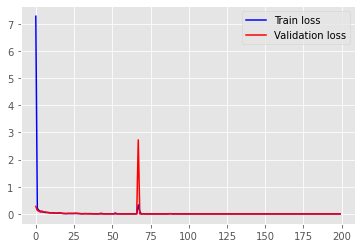

In [22]:


plt.plot(list(range(0,epochs)), train_loss, color='blue', label='Train loss')
plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()

In [42]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image

with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    input, target = next(dataiter)
    print(input.size())
    data = input[1].to(device)
    data = data.unsqueeze(0)
    labels = target[1].to(device)
    labels = labels.unsqueeze(0)

    reconstruction, mu, log_var, bce, kl, loss ,z = model(data,labels)
   

torch.Size([64, 3, 96, 96])


In [43]:
input_img = input[1]
target_img = target[1]
out_img = reconstruction.cpu().squeeze(0)
#out_img = out_img.view(data.size(0), -1)
#out_img = out_img.reshape(3,96,96)

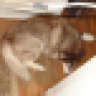

In [37]:
torchvision.transforms.ToPILImage()(input_img)

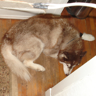

In [38]:
torchvision.transforms.ToPILImage()(target_img)

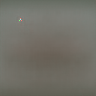

In [39]:
torchvision.transforms.ToPILImage()(out_img)

In [44]:
compare_images(input_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(74.84465939524357, 0.9009545866651045)

In [45]:
compare_images(out_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(57.106765196486215, 0.5683391636142584)

Save images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                          shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(val_loader)

In [ ]:
input, target = next(dataiter)

In [ ]:
input.size()

In [ ]:
im = target.squeeze(1)
im.size()

In [ ]:
from torchvision.utils import save_image

save_image(im, '/content/drive/MyDrive/Deep_Learning/Data/images/STL5.bmp')